# Modeling Workflow Example - Greenplum Database

----

Greenplum Database features used

* Apache MADlib - http://madlib.apache.org/
* Procedural language extension to Python - https://gpdb.docs.pivotal.io/530/ref_guide/extensions/pl_python.html

----

Example uses Credit Approval Data Set found at UCI Machine Learning Repository

http://archive.ics.uci.edu/ml/datasets/Credit+Approval

----

## Index

### Setup 

* <a href="#dependencies">Dependencies</a>
* <a href="#package_options">Package Options</a>
* <a href="#database_connection">Database Connection</a>
    
    
### Data Loading

* <a href="#external_table">External Table Definition</a>
* <a href="#download_data">Download Data</a>
* <a href="#view_sample">View Sample</a>


### Data Audit

* <a href="#summary_statistics">Summary Statistics</a>


### Data Exploration

* <a href="#de_categorical">Categorical Columns</a>
* <a href="#de_continuous">Continuous Columns</a>


### Feature Engineering

* <a href="#fe_continuous">Continuous Features</a>
* <a href="#fe_one_hot">One Hot Encode Categorical Features</a>
* <a href="#fe_combine">Combine Continuous & Categorical Features</a>
* <a href="#fe_corr">Correlation Testing</a>
* <a href="#fe_scatter">Scatter Plots</a>
* <a href="#fe_chi_sq">Chi-squared Testing</a>


### Model Development

* <a href="#train_vali_split">Training & Validation Sample Split</a>

**Random Forest**
* <a href="#rf_train_model">Train model</a>
* <a href="#rf_variable_importance">Variable Importance</a>
* <a href="#rf_score_out_of_sample">Score Validation Data</a>
* <a href="#rf_confusion_matrix">Confusion Matrix</a>
* <a href="#rf_auc">Area Under ROC Curve</a>
* <a href="#rf_roc">Receiver Operating Characteristic Graph (ROC Curve)</a>

### Functions

* <a href="#bar_plot">bar_plot()</a>

----


----
## Setup

<a id="dependencies"></a>

In [1]:
# dependencies
import psycopg2
import pandas as pd
import xlrd
import urllib
import re
import seaborn as sns
import datetime
import math
from textwrap import wrap
#from matplotlib import pyplot as plt

import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

<a id="package_options"></a>

In [2]:
# package options
%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (12, 8)
    
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_colwidth', -1)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


<a id="database_connection"></a>

In [5]:
# init to default values
database_host = 'gpdb'
database_databasename = 'gpadmin'
database_username = 'gpadmin'
database_password = 'pivotal'

# interpret string as markdown
def printmd(string):
    display(Markdown(string))
    
# forms
message = "### Connection Details \n ------"
printmd(message)
    
printmd("**Host:**")
inputHost = widgets.Text()
display(inputHost)

printmd("**Database Name:**")
inputDatabaseName = widgets.Text()
display(inputDatabaseName)

printmd("**Username:**")
inputUsername = widgets.Text()
display(inputUsername)

printmd("**Password:**")
inputPassword = widgets.Text()
display(inputPassword)

printmd("*Leave blank for default values*")


def db_connect():
    global conn, cur
    try:
        conn = psycopg2.connect("host='{}' dbname='{}' user='{}' password='{}'".format(database_host,database_databasename,database_username,database_password))
        cur = conn.cursor()
        conn.autocommit = True
        message = "<span style='color:green'>**Connection successful!**</span>"
        printmd(message)
    except:
        message = "<span style='color:red'>**ERROR: Unable to connect to the database**</span>"
        printmd(message)
    
def on_button_click(b):
    
    global database_host, database_databasename, database_username, database_password
    
    clear_output()
    
    message = "### Connection Details \n ------"
    printmd(message)
    
    if inputHost.value == "":
        message = "**Host:** {} (default)".format(database_host)
        printmd(message)
    else:
        database_host = inputHost.value
        message = "**Host:** {}".format(database_host)
        printmd(message)
  
    if inputDatabaseName.value == "":
        message = "**Database name:** {} (default)".format(database_databasename)
        printmd(message)
    else:
        database_databasename = inputDatabaseName.value
        message = "**Database name:** {}".format(database_databasename)
        printmd(message)
        
    if inputUsername.value == "":
        message = "**Username:** {} (default)".format(database_username)
        printmd(message)
    else:
        database_username = inputUsername.value
        message = "**Username:** {}".format(database_username)
        printmd(message)
        
    if inputPassword.value == "":
        message = "**Password:** {} (default)".format(database_password)
        printmd(message)
    else:
        database_password = inputPassword.value
        message = "**Password:** ###########"
        printmd(message)
    
    printmd("------")
    db_connect()
        
button = widgets.Button(description="Connect")
display(button)
button.on_click(on_button_click)

### Connection Details 
 ------

**Host:** gpdb (default)

**Database name:** gpadmin (default)

**Username:** gpadmin (default)

**Password:** pivotal (default)

------

<span style='color:green'>**Connection successful!**</span>

----
## Data Loading

<a id="external_table"></a>

In [6]:
# create external web table
ddl = """
    DROP EXTERNAL TABLE IF EXISTS public.credit_application_external;
    CREATE EXTERNAL WEB TABLE public.credit_application_external (
        a1 varchar(1)
       ,a2 float
       ,a3 float
       ,a4 varchar(1)
       ,a5 varchar(2)
       ,a6 varchar(2)
       ,a7 varchar(2)
       ,a8 float
       ,a9 boolean
       ,a10 boolean
       ,a11 float
       ,a12 boolean
       ,a13 varchar(1)
       ,a14 float
       ,a15 float
       ,a16 varchar(1)
    ) LOCATION ('http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data')
    FORMAT 'CSV'
    SEGMENT REJECT LIMIT 25;
"""
cur.execute(ddl)

<a id="download_data"></a>

In [7]:
query = """
    DROP TABLE IF EXISTS public.credit_application_data;
    CREATE TABLE public.credit_application_data AS
    SELECT row_number() OVER() AS _id
          ,CASE WHEN a1 = '?' THEN 'b' ELSE a1 END AS a1
          ,a2,a3,a4,a5
          ,CASE WHEN a6 = '?' THEN 'c' ELSE a6 END AS a6
          ,CASE WHEN a7 = '?' THEN 'v' ELSE a7 END AS a7
          ,a8,a9,a10,a11,a12,a13,a14,a15
          ,CASE WHEN a16 = '+' THEN 1 ELSE 0 END AS a16
    FROM public.credit_application_external
    DISTRIBUTED RANDOMLY;
"""
cur.execute(query)

<a id="view_sample"></a>

In [8]:
# view sample
query = """
    SELECT *
    FROM public.credit_application_data
    LIMIT 10
"""
cur.execute(query)
colnames = [desc[0] for desc in cur.description]
pd.DataFrame(cur.fetchall(), columns=colnames)

,_id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
0,2,a,58.67,4.460,u,g,q,h,3.040,True,True,6.0,False,g,43.0,560.0,1
1,4,b,27.83,1.540,u,g,w,v,3.750,True,True,5.0,True,g,100.0,3.0,1
2,6,b,32.08,4.000,u,g,m,v,2.500,True,False,0.0,True,g,360.0,0.0,1
3,8,a,22.92,11.585,u,g,cc,v,0.040,True,False,0.0,False,g,80.0,1349.0,1
4,10,b,42.50,4.915,y,p,w,v,3.165,True,False,0.0,True,g,52.0,1442.0,1
5,12,b,29.92,1.835,u,g,c,h,4.335,True,False,0.0,False,g,260.0,200.0,1
6,14,b,48.08,6.040,u,g,k,v,0.040,False,False,0.0,False,g,0.0,2690.0,1
7,16,b,36.67,4.415,y,p,k,v,0.250,True,True,10.0,True,g,320.0,0.0,1
8,18,a,23.25,5.875,u,g,q,v,3.170,True,True,10.0,False,g,120.0,245.0,1
9,20,a,19.17,8.585,u,g,cc,h,0.750,True,True,7.0,False,g,96.0,0.0,1


----
## Data Audit

<a id="summary_statistics"></a>
Summary Statistics

In [9]:
# drop existing table & run madlib summary stats function
query = """
    DROP TABLE IF EXISTS public.credit_application_summary;
    SELECT madlib.summary('public.credit_application_data','public.credit_application_summary');
"""
cur.execute(query)

# grab results from gpdb
query = """
    SELECT * FROM public.credit_application_summary;
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
data_summary = pd.DataFrame(cur.fetchall(), columns=colnames)

In [10]:
data_summary

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,_id,1,int8,666,666,0,NaN,0.0,NaN,333.500000,3.701850e+04,1.00,666.00,167.2500,333.50,499.7500,"[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,None,None,a1,2,varchar,666,2,0,0.0,0.0,0.0,NaN,NaN,1.00,1.00,NaN,NaN,NaN,"[b, b, a, a]","[463, 463, 203, 203]"
2,None,None,a2,3,float8,666,345,0,NaN,0.0,NaN,31.569054,1.420906e+02,13.75,80.25,22.6025,28.50,38.2500,"[22.67, 25, 24.5, 20.67, 23.58, 19.17, 20.42, 18.83, 22.5, 23]","[9, 6, 6, 6, 6, 6, 6, 6, 6, 5]"
3,None,None,a3,4,float8,666,213,0,NaN,0.0,NaN,4.798078,2.505312e+01,0.00,28.00,1.0100,2.75,7.2075,"[1.5, 1.5, 2.5, 2.5, 3, 3, 0.75, 1.25, 1.25, 0.5]","[20, 20, 19, 19, 18, 18, 16, 16, 16, 14]"
4,None,None,a4,5,varchar,666,3,0,0.0,0.0,0.0,NaN,NaN,1.00,1.00,NaN,NaN,NaN,"[u, u, y, y, l]","[508, 508, 156, 156, 2]"
5,None,None,a5,6,varchar,666,3,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[g, g, p, p, gg]","[508, 508, 156, 156, 2]"
6,None,None,a6,7,varchar,666,14,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[c, c, q, q, w, w, i, i, aa, aa]","[138, 138, 77, 77, 64, 64, 56, 56, 53, 53]"
7,None,None,a7,8,varchar,666,9,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[v, v, h, h, bb, bb, ff, ff, j, z]","[391, 391, 138, 138, 55, 55, 54, 54, 8, 8]"
8,None,None,a8,9,float8,666,131,0,NaN,0.0,NaN,2.222320,1.120642e+01,0.00,28.50,0.1650,1.00,2.5850,"[0, 0, 0.25, 0.25, 0.04, 0.04, 1, 1, 0.125, 0.125]","[61, 61, 34, 34, 33, 33, 31, 31, 30, 30]"
9,None,None,a9,10,bool,666,2,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[t, t, f, f]","[352, 352, 314, 314]"


----
## Data Exploration

<a id="de_categorical"></a>
#### Categorical Columns

-----
 **Select Column:**

A Jupyter Widget

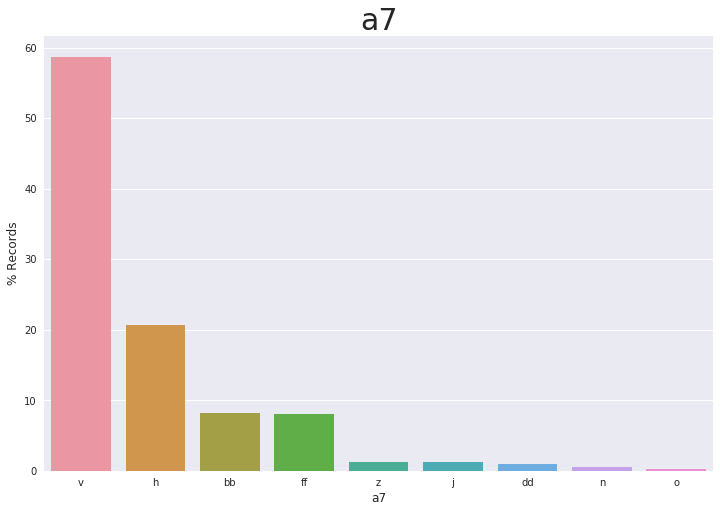

In [11]:
catColumns = ['a1','a4','a5','a6','a7','a9','a10','a12','a13','a16']

def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=12)
    plt.set_ylabel(yLabel,fontsize=12)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')


def get_cat_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,count(*) AS record_count
            FROM public.credit_application_data
            GROUP BY 1
        ) foo
        ORDER BY perc_records DESC
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        clear_output()
        printmd("-----\n **Select Column:**")
        display(catDropdown)
        df = get_cat_data_frame(res['new'])
        bar_plot(df,res['new'],"col",res['new'],"perc_records","% Records", None, 0)
    
catDropdown = widgets.Dropdown(
    options=catColumns,
    value=catColumns[0],
    description='Column:',
    disabled=False,
)

catDropdown.observe(on_cat_selection)
printmd("-----\n **Select Column:**")
display(catDropdown)
df = get_cat_data_frame(catColumns[0])
bar_plot(df,catColumns[0],"col",catColumns[0],"perc_records","% Records", None, 0)

<a id="de_continuous"></a>
#### Continuous Columns

-----
 **Select Column:**

A Jupyter Widget

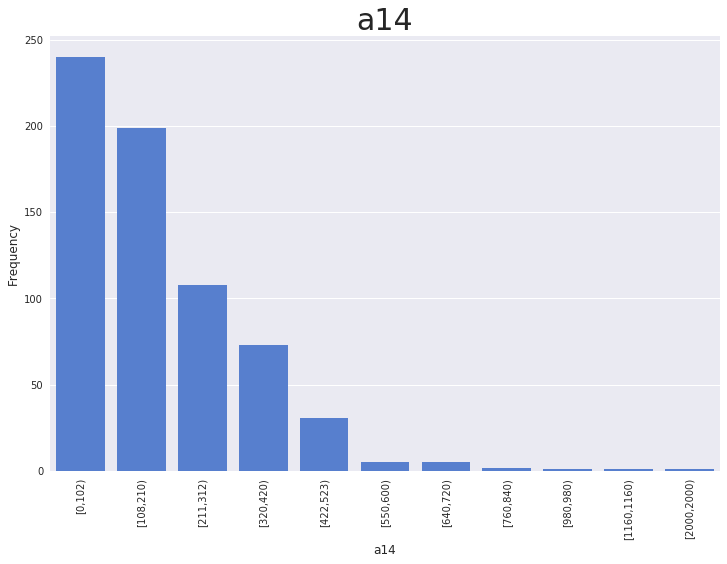

In [12]:
contColumns = ['a2','a3','a8','a11','a14','a15']

def get_cont_data_frame(col):
    query = """
        WITH aggs AS (
            SELECT min({c}) AS min,
                   max({c}) AS max
              FROM public.credit_application_data
        )
        SELECT width_bucket({c}, min, max, 19) AS bucket,
               ('[' || min({c}) || ',' || max({c}) || ')')::text as range,
               count(*) as freq
        FROM public.credit_application_data, aggs
        GROUP BY bucket
        ORDER BY bucket
    """.format(c=col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cont_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        clear_output()
        printmd("-----\n **Select Column:**")
        display(contDropdown)
        df = get_cont_data_frame(res['new'])
        bar_plot(df,res['new'],"range",res['new'],"freq","Frequency", "#4378E2")
        
# Look at log transforms
# colsAddLogs = contColumns + ["log({} + 1)".format(c) for c in contColumns]
colsAddLogs = contColumns

contDropdown = widgets.Dropdown(
    options=colsAddLogs,
    value=colsAddLogs[0],
    description='Column:',
    disabled=False,
)

contDropdown.observe(on_cont_selection)
printmd("-----\n **Select Column:**")
display(contDropdown)
df = get_cont_data_frame(contColumns[0])
bar_plot(df,contColumns[0],"range",contColumns[0],"freq","Frequency", "#4378E2")



*Note - Consider variable transformation if test non-tree based algorithm.*

----
## Feature Engineering

<a id="fe_continuous"></a>
#### Continuous Features

In [13]:
# continuos features (seperated out incase feature transformations are required)
query = """
    DROP TABLE IF EXISTS public.model_inputs_cont;
    CREATE TABLE public.model_inputs_cont AS
    SELECT _id
          ,a16 AS approval
          ,a2
          ,a3
          ,a8
          ,a11
          ,a14
          ,a15
    FROM public.credit_application_data
    DISTRIBUTED BY (_id);
    SELECT * FROM public.model_inputs_cont LIMIT 0;
"""
cur.execute(query)

contFeatureNames = [desc[0] for desc in cur.description]
contFeatureNames.remove('_id')
contFeatureNames.remove('approval')

query = """
    SELECT *
    FROM public.model_inputs_cont
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

print len(df)

df.head()

666


,_id,approval,a2,a3,a8,a11,a14,a15
0,155,1,34.08,0.08,0.04,1.0,280.0,2000.0
1,157,1,44.00,2.00,1.75,2.0,0.0,15.0
2,159,1,32.00,1.75,0.04,0.0,393.0,0.0
3,161,1,40.83,10.00,1.75,0.0,29.0,837.0
4,163,1,32.33,0.54,0.04,0.0,440.0,11177.0


<a id="fe_one_hot"></a>
#### One Hot Encode Categorical Features

In [14]:
# encode categorical features
# https://madlib.apache.org/docs/latest/group__grp__encode__categorical.html
query = """
    DROP TABLE IF EXISTS public.model_inputs_cat;
    SELECT madlib.encode_categorical_variables (
        'public.credit_application_data',
        'public.model_inputs_cat',
        'a1,a4,a5,a6,a7,a9,a10,a12,a13',
        NULL,
        '_id',
        NULL,
        'a1=b, a4=y, a5=p, a6=x, a7=z, a9=False, a10=False, a12=False, a13=s'
    );
"""
cur.execute(query)

query = """
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a9_True" TO a9_true;
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a10_True" TO a10_true;
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a12_True" TO a12_true;
"""
cur.execute(query)

query = """
    SELECT *
    FROM public.model_inputs_cat
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

colnames.remove('_id')
catFeatureNames = colnames
featureNames = contFeatureNames + catFeatureNames
print featureNames
df.head()

['a2', 'a3', 'a8', 'a11', 'a14', 'a15', 'a1_a', 'a4_l', 'a4_u', 'a5_g', 'a5_gg', 'a6_aa', 'a6_c', 'a6_cc', 'a6_d', 'a6_e', 'a6_ff', 'a6_i', 'a6_j', 'a6_k', 'a6_m', 'a6_q', 'a6_r', 'a6_w', 'a7_bb', 'a7_dd', 'a7_ff', 'a7_h', 'a7_j', 'a7_n', 'a7_o', 'a7_v', 'a9_true', 'a10_true', 'a12_true', 'a13_g', 'a13_p']


,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p
0,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0
1,157,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
2,159,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0
3,161,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,163,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0


<a id="fe_combine"></a>
#### Combine Continuous & Categorical Features

In [15]:
# combine feature tables
query = """
    DROP TABLE IF EXISTS public.model_inputs;
    CREATE TABLE public.model_inputs AS
    SELECT *
    FROM public.model_inputs_cat
    JOIN public.model_inputs_cont
    USING (_id);
"""
cur.execute(query)

<a id="fe_corr"></a>
#### Correlation Testing

In [16]:
# calc correlations
query = """
    DROP TABLE IF EXISTS public.feature_correlations, public.feature_correlations_summary;
    SELECT madlib.correlation( 
        'public.model_inputs',
        'public.feature_correlations',
        '{}'
    );
    SELECT * 
    FROM public.feature_correlations
    ORDER BY column_position;
""".format(",".join(contFeatureNames))
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
corr = pd.DataFrame(cur.fetchall(), columns=colnames)
corr.drop('column_position', 'columns', inplace=True)
corr.set_index('variable', True, False, True)
corr

,a2,a3,a8,a11,a14,a15
variable,,,,,,
a2,1.000000,NaN,NaN,NaN,NaN,NaN
a3,0.211249,1.000000,NaN,NaN,NaN,NaN
a8,0.404847,0.303990,1.000000,NaN,NaN,NaN
a11,0.190790,0.271777,0.329274,1.000000,NaN,NaN
a14,-0.079812,-0.217364,-0.069020,-0.118024,1.000000,NaN
a15,0.027512,0.120021,0.053009,0.059604,0.069396,1.0


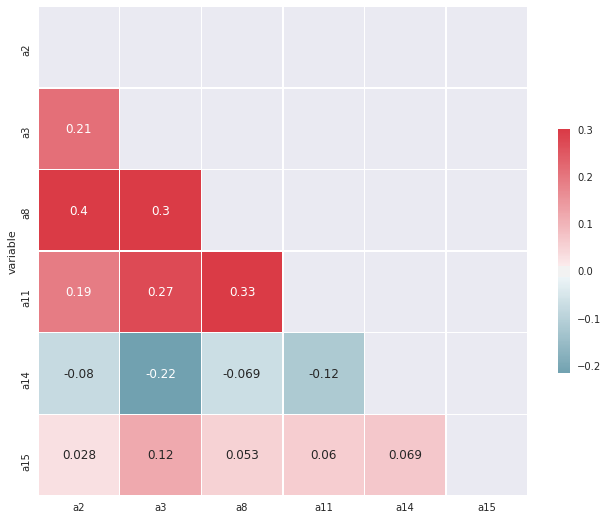

In [17]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<a id="fe_scatter"></a>
#### Scatter Plots

In [18]:
def sample_scatter(title, x, xLabel, y, yLabel, sampleSize):
    
    pylab.rcParams['figure.figsize'] = (8, 8)

    # Grab sample
    query = """
        SELECT count(*) AS n
        FROM public.model_inputs;
    """.format(",".join(contFeatureNames))
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    n = pd.DataFrame(cur.fetchall(), columns=colnames)['n'][0]
    limit = math.floor(n * sampleSize)
    
    query = """
        SELECT {}, {}
        FROM public.model_inputs
        LIMIT {};
    """.format(x, y, limit)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    sample = pd.DataFrame(cur.fetchall(), columns=colnames)    
    
    # Generate scatterplot
    plt = sns.regplot(x="{}".format(x), y="{}".format(y), data=sample)
    
    # titles
    plt.set_title("\n".join(wrap(title,50)),fontsize=16)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)

    # add 1000s commas
    plt.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    plt.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

-----
 **Select Features:**

A Jupyter Widget

A Jupyter Widget

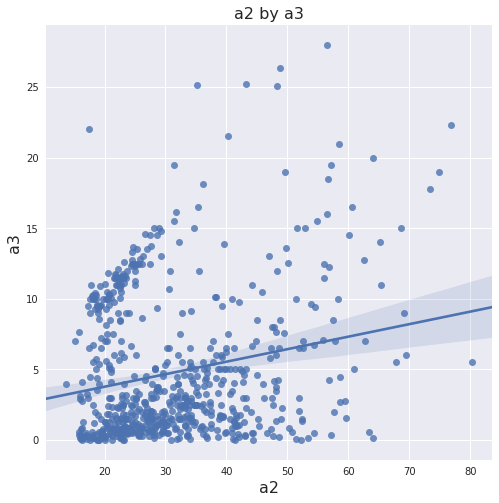

In [19]:
x = contFeatureNames[0]
y = contFeatureNames[1]

def reset():
    clear_output()
    printmd("-----\n **Select Features:**")
    display(scatterDropdown1, scatterDropdown2)

    sample_scatter("{} by {}".format(x, y), x, x, y, y, 1)   
    
def os1(res):
    global x
    if res['type'] == 'change' and res['name'] == 'value':
        x = res['new']
        reset()

def os2(res):
    global y
    if res['type'] == 'change' and res['name'] == 'value':
        y = res['new']
        reset()
                   
scatterDropdown1 = widgets.Dropdown(
    options=contFeatureNames,
    value=x,
    description='x:',
    disabled=False,
)

scatterDropdown2 = widgets.Dropdown(
    options=contFeatureNames,
    value=y,
    description='y:',
    disabled=False,
)

scatterDropdown1.observe(os1)
scatterDropdown2.observe(os2)

reset()


<a id="fe_chi_sq"></a>
#### Chi-squared testing

In [20]:
# continuous columns (excludes rate_spread with 96.8% missing)
catColumns = [
    'as_of_year',
    'loan_purpose',
    'purchaser_type',
    'applicant_race_1',
    'property_type',
    'applicant_sex',
    'applicant_ethnicity',
    'agency_code',
    'co_applicant_ethnicity',
    'hoepa_status',
    'lien_status',
    'loan_type',
    'owner_occupancy',
    'preapproval',
    'state_code'
]

# copy list and add action_taken element
catColumnsWithDependent = list(catColumns)
catColumnsWithDependent.append('action_taken')

# Create 5% sample of data with categorical data and dependent
dfDependent = df.select(catColumnsWithDependent).sample(False, 0.05, seed=12345)

# Cast all values as int 
# TO DO: Make sure column types are correct during import
dfDependent = dfDependent.select(*(col(c).cast('int').alias(c) for c in dfDependent.columns))

# Impute value for missing
dfDependent = dfDependent.na.fill(-1)

# Create dependent
columnDefinition = when(col('action_taken') == 1, 1).when(col('action_taken') == 2, -1).otherwise(0) 
dfDependent =  dfDependent.withColumn('approved_class',columnDefinition)

# Remove action_taken == 2
dfDependent = dfDependent.where(col('action_taken') != 2)

# Sanity Check
sanityCheck = dfDependent.groupBy(['approved_class','action_taken']).count().toPandas()
sanityCheck = sanityCheck.sort_values('action_taken')
display(sanityCheck)

# create vector
assembler = VectorAssembler(
    inputCols=[c for c in catColumns],
    outputCol='features')
dfDenseVector = assembler.transform(dfDependent)

# Run chi-squared test
chiSquaredResults = ChiSquareTest.test(dfDenseVector, "features", "approved_class").toPandas()

# Transform results for easier reading
chiSquaredResults['feature_names'] = [catColumns]
chiSquaredResults = pd.DataFrame({
    'Feature names': chiSquaredResults['feature_names'].loc[0],
    'p-values': chiSquaredResults['pValues'].loc[0],
    'Degrees of freedom': chiSquaredResults['degreesOfFreedom'].loc[0],
    'Test statistic': chiSquaredResults['statistics'].loc[0]
}).sort_values('Test statistic',ascending=True)

display(chiSquaredResults)

TypeError: 'list' object is not callable

In [21]:
# bar_plot(data, title, x, xLabel, y, yLabel)
bar_plot(chiSquaredResults, "Chi-Squared Testing", "Feature names", "Feature Name", "Test statistic", "X^2 Test Statistic","#4378E2")

NameError: name 'chiSquaredResults' is not defined

----
## Model Training

In [22]:
# split training and validation set
# we are careful not to include the same customer in both sets
# https://madlib.apache.org/docs/latest/group__grp__train__test__split.html
query = """
    DROP TABLE IF EXISTS public.model
                        ,public.model_train
                        ,public.model_test;
                        
    SELECT madlib.train_test_split(
        'public.model_inputs',
        'public.model',
        0.7,
        NULL,
        NULL,
        '*',
        FALSE,
        TRUE
    )
"""
cur.execute(query)

In [23]:
query = """
    SELECT *
    FROM public.model_train
    LIMIT 5
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)
df

,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p,approval,a2,a3,a8,a11,a14,a15
0,6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,32.08,4.000,2.500,0.0,360.0,0.0
1,14,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,48.08,6.040,0.040,0.0,0.0,2690.0
2,17,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,28.25,0.875,0.960,3.0,396.0,0.0
3,26,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,15.83,0.585,1.500,2.0,100.0,0.0
4,35,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,22.58,10.750,0.415,5.0,0.0,560.0


In [ ]:
# traing random forest model
# https://madlib.apache.org/docs/latest/group__grp__random__forest.html
query = """
DROP TABLE IF EXISTS public.rf_model_output, public.rf_model_output_summary, public.rf_model_output_group;
SELECT madlib.forest_train(
            'public.model_train',
            'public.rf_model_output',
            '_id',
            'approval',
            '{}',
            null,
            null,
            40::integer,
            10::integer,
            true::boolean,
            1::integer,
            8::integer,
            3::integer,
            1::integer,
            10::integer
        )
""".format(','.join(featureNames))
cur.execute(query)

In [ ]:
# view model summary
query = """
    SELECT *
    FROM public.rf_model_output_summary
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)
df

In [ ]:
# feature importance
query = """
    SELECT 'cat' AS type
          ,unnest(string_to_array(cat_features,',')) AS feature_name
          ,unnest(cat_var_importance) AS feature_importance
    FROM public.rf_model_output_group l
        ,public.rf_model_output_summary r
    UNION
    SELECT 'con' AS type
          ,unnest(string_to_array(con_features,',')) AS feature_name
          ,unnest(con_var_importance) AS feature_importance
    FROM public.rf_model_output_group l
        ,public.rf_model_output_summary r
    ORDER BY 3
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

bar_plot(df,"Feature Importance","feature_name",'Feature Name',"feature_importance","Feature Importance", "#4378E2")

In [ ]:
# Score out-of-sample
query = """
    DROP TABLE IF EXISTS public.model_test_scored;
    SELECT madlib.forest_predict('public.rf_model_output',
                                 'public.model_test',
                                 'public.model_test_scored',
                                 'prob');
                
    DROP TABLE IF EXISTS public.model_test_scored_tmp;
    CREATE TABLE public.model_test_scored_tmp AS
    SELECT *
    FROM public.model_test_scored
    JOIN public.model_test
    USING (_id);
    DROP TABLE public.model_test_scored;
    ALTER TABLE public.model_test_scored_tmp RENAME TO model_test_scored;
    SELECT * FROM public.model_test_scored LIMIT 0;
    
"""
cur.execute(query)

In [ ]:
# auc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_auc;
    SELECT madlib.area_under_roc(
        'public.model_test_scored'
       ,'public.model_test_scored_auc'
       ,'estimated_prob_1'
       ,'approval'
    )
"""
cur.execute(query)

query = """
    SELECT * 
    FROM public.model_test_scored_auc;
"""
cur.execute(query)
colnames = [desc[0] for desc in cur.description]
auc = (pd.DataFrame(cur.fetchall(), columns=colnames))['area_under_roc'][0]

message = """-----\n **AUC =** {:0.5f}""".format(auc)
printmd(message)

message = """

**Previous Iterations:**
1. AUC = 0.81559
2. AUC = 0.90879
3. AUC = 0.91903
4. AUC = 0.95987
"""
printmd(message)

In [ ]:
# roc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_roc;
    SELECT madlib.binary_classifier( 
        'public.model_test_scored'
       ,'public.model_test_scored_roc'
       ,'estimated_prob_1'
       ,'approval'
    );
"""
cur.execute(query)

query = """
    SELECT * 
    FROM public.model_test_scored_roc
    ORDER BY 1
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

# roc curve
pylab.rcParams['figure.figsize'] = (8, 8)

plt.figure()
lw = 2
plt.plot(df['fpr'], df['tpr'], color='darkgreen', lw=lw, label='AUC {:0.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# confusion matrix (inclusive)
cutoff = 0.5

query = """
    SELECT approval AS obs
          ,CASE WHEN estimated_prob_1 >= {} THEN 1 ELSE 0 END AS pred
          ,count(*) AS num
    FROM public.model_test_scored
    GROUP BY 1,2
    ORDER BY 1,2
""".format(cutoff)
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
pd.DataFrame(cur.fetchall(), columns=colnames)
